# Round 8. Network sampling

To get started, you can use the provided Python template `sampling.py` or this notebook for reference. The usage of the notebook or template is **optional**. Then you only need to fill in the required functions. Some of the functions do NOT need modifications. You may start your solution after the subtitle "**Beginning of the Exercise**" down below. 

In addition to returning a short report of your results (including the visualizations), return also your commented Python code or notebook. Remember to label the axes in your figures!

## Introduction
Many network data sets are samples of some underlying graphs that we are actually interested in. That is, nodes and edges of these empirical networks have been sampled in a way that we only observe parts of the network. This can severely bias even the most simple network measures so that the sampled graph has quantitatively different properties when compared to the underlying graph.
In this exercise we will see the effect of three different sampling schemes on network transitivity $C$ (also known as the global clustering coefficient) and derive estimators that can be used to correct for these biases.  

Let us first recall the definition of transitivity $C$:
\begin{equation} \label{eq1}
C =\frac{\tau_{\triangle}}{\tau_{\angle}} = \frac{\sum_i E_i}{\sum_i {k_i \choose 2}}\,, %=\frac{\text{3} \times \text{number of triangles in the network}}{\text{number of two-stars in the network}}\,,
\end{equation}
where $\tau_{\triangle}$ is three times the nuber of triangles \footnote{This is three times the number of triangles as we are going through all the nodes - and thus counting each triangle three times. We could define an alternative estimator that corrects for this overestimation, but for transitivity $\tau_{\triangle} = \sum_i E_i$ suffices.} (three nodes that are fully connected), 
$\tau_{\angle}$ is the number of two-stars (a node and two of its neighbors, regardless of whether they are triangles), 
$i$ is a node, $k_i$ is the degree of $i$, and $E_i$ is the number of triangles centered on $i$ (in other words, how many triangles pass by $i$).

# Beginning of the exercise
Write your code for the sampling exercise when needed

Start by generating a network from a random model. Use the command `{nx.relaxed_caveman_graph(200, 10, 0.1)}` to generate a graph with 200 communities of ten people each, where each link is then rewired with probability $0.1$. This is the "true" underlying graph from which we obtain samples.

In [19]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Generate network
g = nx.relaxed_caveman_graph(200, 10, .1)

### a. Three sampling schemes
First, let's implement the three sampling schemes. Program three functions that perform:
1. Bernoulli sampling of nodes: iterate over nodes, and sample each one with probability $p$. We observe an edge if and only if we have sampled its two constituting nodes. 
2. Bernoulli sampling of edges: iterate over edges, and sample each one with probability $p$. We observe a node if and only if we have sampled at least one of its edges.
3. Star sampling: iterate over nodes, and sample each one with probability $p$. If you have directly sampled a node, you also observe all of its neighbors (a real-life example would be a data set obtained by crawling through friendship lists of randomly selected users in a social networking website). Note: here we will have nodes that are sampled a) directly with probability $p$ and b) indirectly via sampling a neighbor. It is useful to keep a list of nodes you sampled directly. 


In [20]:
def sample_nodes(g, p):
    """
    Sample a graph via Bernoulli node sampling.
    For each node in g, sample it with probability p, and add edge (i, j) only if both nodes i and j have been sampled.

    Parameters
    ----------------
    g: a networkx graph object
    p: sampling probability for each node
    """

    # Initialize empty network
    g_new = nx.empty_graph()
    
    ###TIP: #TODO: Write code for sampling. Iterate over nodes, and add to g_new with probability p
    ###TIP: #TODO Add edges if both nodes in an edge have been observed.
    for node in list(g.nodes()):
        if(np.random.random()<p):
            g_new.add_node(node)
            for n in g.neighbors(node):
                if n in g_new:
                    g_new.add_edge(node,n)  
    return g_new

In [21]:
def sample_edges(g, p):
    """
    Sample a graph via Bernoulli edge sampling.
    For each edge in g, sample it with probability p

    Parameters
    ----------------
    g: a networkx graph object
    p: sampling probability for each edge
    """

    # Initialize empty network
    g_new = nx.empty_graph()

    # TODO: Write code for sampling. Iterate over edges, and add to g_new with probability p
    # YOUR CODE HERE
    for edge in list(g.edges()):
        if(np.random.random()<p):
            g_new.add_edge(*edge)
            g_new.add_nodes_from(edge)
    #raise NotImplementedError()
    return g_new

**Hints**
- For star sampling, there are at least two ways of counting the sampled two-stars: we can either focus on the directly sampled nodes and obtain their full degrees, or we can count all the two-stars regardless of whether the center node itself was selected (so if two nodes with the same neighbor are selected, we observe a two-star centered on a node not directly sampled). Both answers are correct, but using the directly-sampled nodes will make calculations easier on the next excercise.

In [22]:
def sample_stars(g, p):
    """
    Sample a graph via star sampling.
    We sample nodes with probability p, and observe all neighbors. Returns a g_new network obtained via star sampling, and also a list of the nodes that were directly sampled from g, not only sampled via observing a sampled neighbor.
    Parameters
    ----------------
    g: a networkx graph object
    p: sampling probability of sampling a node (and observing its neighbors)
    """

    # Initialize empty network
    g_new = nx.empty_graph()
    nodes = []
    # TODO: Write code for sampling. Iterate over nodes, and add to g_new with probability p
    for node in list(g.nodes()):
        if(np.random.random()<p):
            nodes.append(node)
            g_new.add_node(node)
    # TODO: If a node has been observed, then add all the node's neighbors to the graph
            for n in g.neighbors(node):
                g_new.add_node(n)
                g_new.add_edge(node,n)  
    # TODO: Use nodes to keep a list of directly sampled nodes
    # YOUR CODE HERE
    #raise NotImplementedError()
    return g_new, nodes

In [23]:
g_new,nodes = sample_stars(g, 0.4)

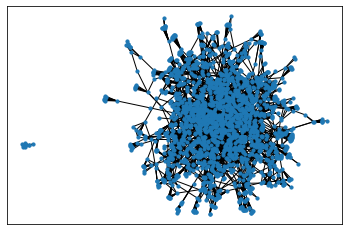

In [24]:
nx.draw_networkx(g_new,with_labels=False,node_size=10)

**Obtain samples** of the network using the three sampling schemes with probability $p = 0.4$. Then, use either the code we provided or your own to obtain empirical estimates of the number of triangles, the number of two-stars, and transitivity. **Report** your results on a table where the columns represent:
- sampled number of triangles, 
- sampled number of two-stars
- transitivity in sampled network
- fraction of sampled triangles over triangles in original network
- fraction of sampled two-stars over two-stars in original network

and the rows represent the different sampling schemes (plus an extra row with the values of the original network). **Answer** the following questions: how do sampling schemes compare in the fraction of triangles/two-stars they preseve? Do sampling schemes affect two-stars/triangles in the same way? Transitivity via node sampling should be similar to the real value, what could be the reason for this? 

We provide code for counting triangles, two-stars and computing transitivity. 

In [25]:
def count_twostars(g, nodes=None):
    """
    Counts the number of two stars in a graph

    Parameters
    ------------------
    g: a networkx graph object
    nodes: if nodes is not None, a list of sampled nodes under the star-sampling scheme.
    """
    if not nodes:
        two_stars = [k*(k - 1)/2 for n, k in g.degree()]
    else:
        two_stars = [k*(k - 1)/2 for n, k in g.degree() if n in nodes]
    n_two_stars = sum(two_stars)
    return n_two_stars


def count_triangles(g):
    """
    Counts the number of triangles in a graph

    Parameters
    ------------------
    g: a networkx graph object
    """
    triangles = []
    for node in g.nodes:
        neighbors = [n for n in g.neighbors(node)]
        n_neighbors = len(neighbors)
        n_links = 0
        if n_neighbors > 1:
            for n1 in neighbors:
                for n2 in neighbors:
                    if g.has_edge(n1, n2):
                        n_links += 1
        triangles.append(n_links/2)
    n_triangles = sum(triangles)
    # Another option is to use nx.triangles(), or to count triangles directly

    return n_triangles


def transitivity(n_triangles, n_twostars):
    """
    Returns the plug-in estimator for global transitivity given the number of triangles and number of two-stars.

    Parameters
    ---------------------
    triples: int
    triangles: int
    """
    transitivity = n_triangles/n_twostars

    return transitivity

In [26]:
# a)
# Compute statistics from the original network
n_triangles_orig = count_triangles(g)
n_twostars_orig = count_twostars(g)
transit_orig = transitivity(n_triangles_orig, n_twostars_orig)
p = 0.4

print('samp. |  triangles | two-stars | transit. | triang.frac. | two-st.frac. ')

# Sample nodes
g_new = sample_nodes(g, p)

# Obtain node statistics
n_triangles = count_triangles(g_new)
n_twostars = count_twostars(g_new)
transit = transitivity(n_triangles, n_twostars)
f_triangles_n = n_triangles / n_triangles_orig
f_twostars_n = n_twostars / n_twostars_orig
print('node  |  %8d  |  %7d  |  %1.4f  |    %1.4f    |    %1.4f    ' %
      (n_triangles, n_twostars, transit, f_triangles_n, f_twostars_n))

    # Sample edges
g_new = sample_edges(g, p)

# Obtain edge statistics
n_triangles = count_triangles(g_new)
n_twostars = count_twostars(g_new)
transit = transitivity(n_triangles, n_twostars)
f_triangles_e = n_triangles / n_triangles_orig
f_twostars_e = n_twostars / n_twostars_orig
print('edge  |  %8d  |  %7d  |  %1.4f  |    %1.4f    |    %1.4f    ' % 
      (n_triangles, n_twostars, transit, f_triangles_e, f_twostars_e))

    # Sample stars
g_new, nodes = sample_stars(g, p)

# Obtain star statistics
n_triangles = count_triangles(g_new)
n_twostars = count_twostars(g_new, nodes)
transit = transitivity(n_triangles, n_twostars)
f_triangles_s = n_triangles / n_triangles_orig
f_twostars_s = n_twostars / n_twostars_orig
print('star  |  %8d  |  %7d  |  %1.4f  |    %1.4f    |    %1.4f    ' % 
      (n_triangles, n_twostars, transit, f_triangles_s, f_twostars_s))
print('orig. |  %8d  |  %7d  |  %1.4f  |    %1.4f    |    %1.4f    ' % 
      (n_triangles_orig, n_twostars_orig, transit_orig, 1., 1.))

samp. |  triangles | two-stars | transit. | triang.frac. | two-st.frac. 
node  |      3165  |     4523  |  0.6998  |    0.0595    |    0.0620    
edge  |      3246  |    11426  |  0.2841  |    0.0610    |    0.1567    
star  |     19152  |    29610  |  0.6468  |    0.3598    |    0.4060    
orig. |     53235  |    72932  |  0.7299  |    1.0000    |    1.0000    


The Horvitz-Thompson (HT) estimator is a simple way of correcting for the bias induced by sampling. Let $\hat{\tau}$ be the emprical count of a structure found in a sampled network, such as your results from a). If $p_{\tau}$ is the probability of observing these structures, then the HT estimator for the total counts is simply:
\begin{equation}
\hat{\tau}^{HT} = \frac{1}{p_{\tau}} \hat{\tau}
\end{equation}
For transitivity, we may simply use a "plug-in" estimator by substituting the empirical estimators for the HT estimators; that is, use $\hat{\tau}^{HT}_{\triangle}$ and $\hat{\tau}^{HT}_{\angle}$ instead of $\hat{\tau}_{\triangle}$ and $\hat{\tau}_{\angle}$ in the transitivity formula.

### d. HT estimator
Implement the HT estimator for the three sampling schemes. Given two selection probabilities $p$, we will sample at least $n=100$ times to obtain distributions of some of our HT estimators, and compare it with the measurements from the sampled networks. In other words, for each $p=0.2, 0.5$, and for each sampling scheme, obtain $n=100$ samples from the original network, calculate the HT estimator for the number triangles and for transitivity. For $p=0.5$ include also the empirical estimator (the counts without the HT correction), and for all plots include a vertical line depicticing the value of the original network. As a summary, you will **report your results in six plots**:

- Histograms of estimator $\hat{\tau}_{\triangle}^{HT,n}$ for $p=0.2, 0.5$ and $\hat{\tau}_{\triangle}$ (empirical counts) for $p=0.5$ and true value of $\tau_{\triangle}$.
- Histograms of estimator $\hat{\tau}_{C}^{HT,n}$ for $p=0.2, 0.5$ and $\hat{\tau}_{C}$ (empirical value) for $p=0.5$ and true value of $C$.
-  of estimator $\hat{\tau}_{\triangle}^{HT,e}$ for $p=0.2, 0.5$ and $\hat{\tau}_{\triangle}$ (empirical counts) for $p=0.5$ and true value of $\tau_{\triangle}$.
- Histograms of estimator $\hat{\tau}_{C}^{HT,e}$ for $p=0.2, 0.5$ and $\hat{\tau}_{C}$ (empirical value) for $p=0.5$ and true value of $C$.
- Histograms of estimator $\hat{\tau}_{\triangle}^{HT,s}$ for $p=0.2, 0.5$ and $\hat{\tau}_{\triangle}$ (empirical counts) for $p=0.5$ and true value of $\tau_{\triangle}$.
- Histograms of estimator $\hat{\tau}_{C}^{HT,s}$ for $p=0.2, 0.5$ and $\hat{\tau}^{C}$ (empirical value) for $p=0.5$ and true value of $C$.
\end{itemize}

In your plots, the distribution of HT estimators should lie around the real value. **Answer** the following questions: what is the effect of the sampling probability $p$ on your estimators? How the HT distribuitions differ between sampling schemes? In the last plot, the empirical estimators (without HT correction) should be centered around the true value, why could this be?

**Hints**:
- Since we want to observe how different samples may arise from the same network, we need to take a large number of samples ($n=100$, for instance). However, while you are coding and testing it may be wise to use a smaller $n$. Keep in mind that if your code takes too much time to run on your computer, you can report results for a smaller $n$ or a smaller network.
- In case you were not able to obtain the theoretical probabilitites in excercise b), you can substitute the theoretical probabilities ($p^s_{\triangle}$, for example) with the fraction of sampled structures over the totals in the original network. If this is the case, please state so in your report and explain why this substitution is possible.  


In [27]:
def ht_edge_probabilities(p):
    """
    Given the probability of sampling an edge, returns the probabilities of sampling two-stars and triangles

    Parameters
    ---------------------
    p: float
    """
    pi_twostars = p**2
    pi_triangles = p**3

    return pi_twostars, pi_triangles

In [28]:
def ht_node_probabilities(p):
    """
    Given the probability of sampling a node, returns the probabilities of sampling two-stars and triangles

    Parameters
    ---------------------
    p: float
    """
    pi_twostars = 0
    pi_triangles = 0
    ###TIP: #TODO write the probabilites of sampling twostars and triangles under node sampling
    ###TIP: #NOTE: if you did not obtain the theoretical values, you can use an estimate of pi_twostars 
    ###TIP: #and pi_triangles by sampling nodes with probability p=.2, .5, and using the fraction of sampled 
    ###TIP: #twostars/triangles as estimates.
    # YOUR CODE HERE
    orig_twostars_count = count_twostars(g)
    orig_triangles_count = count_triangles(g)
    g_new = sample_nodes(g, p)    
    new_twostars_count = count_twostars(g_new)
    new_triangle_count = count_triangles(g_new)
    
    
    #return pi_twostars, pi_triangle
    #raise NotImplementedError()
    return (new_twostars_count / orig_twostars_count), (new_triangle_count / orig_triangles_count)

In [29]:
def ht_star_probabilities(p):
    """
    Given the probability of sampling a star, returns the probabilities of sampling two-stars and triangles

    Parameters
    ---------------------
    p: float
    """
    pi_twostars = 0.
    pi_triangles = 0.
    ###TIP: #TODO write the probabilites of sampling twostars and triangles under star-sampling
    ###TIP: #NOTE: if you did not obtain the theoretical values, you can use an estimate of pi_twostars 
    ###TIP: #and pi_triangles by sampling stars with probability p=.2, .5, and using the fraction of sampled 
    ###TIP: #twostars/triangles as estimates.
    # YOUR CODE HERE
    orig_twostars_count = count_twostars(g)
    orig_triangles_count = count_triangles(g)
    g_new = sample_stars(g, p)    
    new_twostars_count = count_twostars(g_new)
    new_triangle_count = count_triangles(g_new)
    
    #return pi_twostars, pi_triangle
    #raise NotImplementedError()
    return (new_twostars_count / orig_twostars_count), (new_triangle_count / orig_triangles_count)
    #raise NotImplementedError()
    #return pi_twostars, pi_triangles

In [30]:
def horvitz_thompson(obs_values, p):
    """
    Returns the Horvitz-Thompson Estimator

    Parameters
    --------------------
    obs_values: int or float, observed values from a sampled network
    p: float, probability of obs_values
    """
    ht = (1 / p) * obs_values

    return ht

In [64]:
def ht_estimators(g, p, n_samp, sampling_type, empirical=False):
    """
    Function for obtaining n_samp samples from a network g and returning the HT estimates, given a sampling type and sampling probabilty p.
    Returns two lists of size n_samp, where each list contains HT estimates for transitivity and number of two-stars.

    Parameters
    ------------------------
    g: a networkx network
    p: float, sampling probability
    n_samp: int, number of samples to obtain
    sampling_type: str, either 'nodes', 'edges' or 'stars'
    empirical: bool, if True, then do not use HT estimators
    """
    transitivity_estimates = []
    triangles_estimates = []

    for i in range(n_samp):
        
        if sampling_type == 'nodes':
            g_new = sample_nodes(g, p)
            nodes = None
            pi_twostars, pi_triangles = ht_node_probabilities(p)

        elif sampling_type == 'edges':
            g_new = sample_edges(g, p)
            nodes = None
            pi_twostars, pi_triangles = ht_edge_probabilities(p)

        elif sampling_type == 'stars':
            g_new, nodes = sample_stars(g, p)
            pi_twostars, pi_triangles = ht_star_probabilities(p)
        else:
            raise ValueError("Invalid sampling_type, must be either 'nodes', 'edges' or 'stars'")
        #TODO: Count the statistics, build the HT estimators, plug-in for transitivity and save sampled value
        #TODO: if empirical = True, simply do not use HT estimators
        #if(empirical!=True):
        transitivity_estimates.append(transitivity(horvitz_thompson(pi_triangles,count_triangles(g_new)),horvitz_thompson(pi_twostars,count_twostars(g_new))))
        #transitivity_estimates[i]=transitivity(count_triangles(g_new), count_twostars(g_new))
        #triangles_estimates.append(transitivity(horvitz_thompson(pi_triangles,count_triangles(g_new)),horvitz_thompson(pi_twostars,count_twostars(g_new))))

        triangles_estimates.append(horvitz_thompson(pi_triangles,count_triangles(g_new)))
        #raise NotImplementedError()

    return transitivity_estimates, triangles_estimates

In [65]:
def plot_triangle_transitivity_histograms(n_samp, sampling_type, g, p_empirical=.5):
    """
    Plot exercise histograms for n_samp samples and a given sampling_type (nodes, edges or stars).
    Calls function ht_estimators for probabilites p=.2, .5, obtaining n_samp samples for each case. 
    Plots the HT estimators for number of triangles and transitivity, and the empirical estimators p=.5, as well 
    as the true values for transitivity and 
    
    Paramters:
    ------------------------
    n_samp: int, number of samples
    sampling_type: str, either 'nodes', 'edges' or 'stars'
    g: networkx graph
    p_empirical: float, probability value for which to obtain empirical estimators (without HR correction). 
    """

    fig = plt.figure(figsize=(8, 5))
    probabilities = [ .2, .5]

    estimator_name_triangles = r'$\hat{\tau}^' + sampling_type[0] + r'_{\bigtriangleup}$'
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title('Estimators for triangles sampling {}, '.format(sampling_type) + estimator_name_triangles)
    ax1.set_xlabel(estimator_name_triangles)

    estimator_name_transit = r'$\hat{\tau}^' + sampling_type[0] + r'_C$'
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title('Estimators for transitivity sampling {}, '.format(sampling_type) + estimator_name_transit)
    ax2.set_xlabel(estimator_name_transit)

    #Plot HT estimates for different probabilities
    for p in probabilities:
        transit_est, triangles_est = ht_estimators(g, p, n_samp, sampling_type)
        ax1.hist(triangles_est, 30, alpha=.5, density=True, label='p = {}'.format(p))
        ax2.hist(transit_est, 30, alpha=.5, density=True, label='p = {}'.format(p))

    #Obtain empirical estimates
    transit_est, triangles_est = ht_estimators(g, p_empirical, n_samp, sampling_type, empirical=True)
    ax1.hist(triangles_est, 30, alpha=.5, density=True, label='p_empirical = {}'.format(p_empirical))
    ax2.hist(transit_est, 30, alpha=.5, density=True, label='p_empirical = {}'.format(p_empirical))

    # Plot real values
    n_triangles_orig = count_triangles(g)
    n_twostars_orig = count_twostars(g)
    transit_orig = transitivity(n_triangles_orig, n_twostars_orig)
    ax1.axvline(n_triangles_orig, color='r') # n_triangles as obtained for the full network
    ax2.axvline(transit_orig, color='r') # transit as obtained for the full network

    ax1.legend(loc=0)
    ax2.legend(loc=0)
    fig.tight_layout()
    fig.savefig('ht_estimator_sampling_{}.pdf'.format(sampling_type))

AttributeError: 'tuple' object has no attribute 'degree'

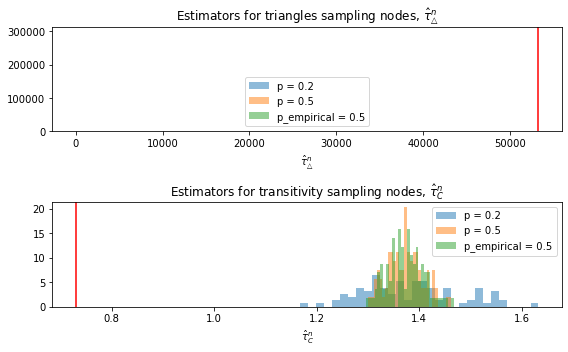

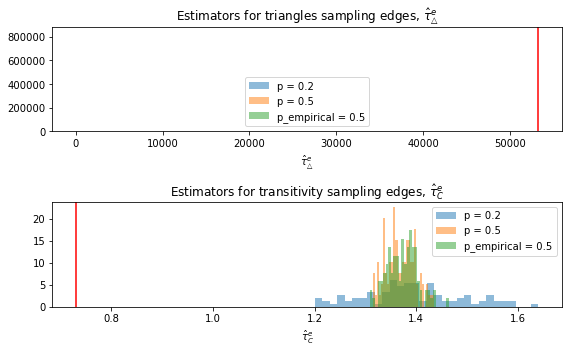

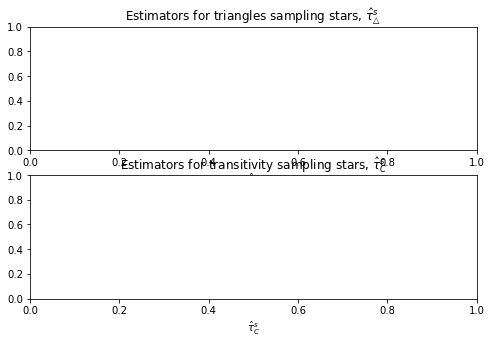

In [66]:
# d)# Histograms for node sampling
n_samp = 100
plot_triangle_transitivity_histograms(n_samp, 'nodes', g, p_empirical=.5)

# Histograms for edge sampling
n_samp = 100
plot_triangle_transitivity_histograms(n_samp, 'edges', g, p_empirical=.5)

# Histograms for star sampling
n_samp = 100
plot_triangle_transitivity_histograms(n_samp, 'stars', g, p_empirical=.5)